In [1]:
import pandas as pd
import numpy as np
from pathlib2 import Path
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import re
import lightgbm as lgb
from datetime import datetime
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

In [2]:
def evraz_metric(true_t, predict_t, true_c, predict_c):

    delta_c = np.abs(np.array(true_c) - np.array(predict_c))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(true_t) - np.array(predict_t))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(predict_c)

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

In [3]:
path = Path('../../../data/2021_evraz')

In [4]:
target_train = pd.read_pickle(path.joinpath('target_train_with_gas_wo_sip.pkl'))
print(target_train.shape)
target_train.head(3)

(2063, 156)


,NPLV,TST,C,VES,T_x,SI,MN,S,P,CR,...,CO,CO2,H2,N2,O2,O2_pressure,T_y,Tfurmy1,Tfurmy2,V_y
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,41565.325339,34936.083312,768.890272,156085.786997,20685.819848,34191.508527,1.297695e+06,0.0,0.0,5.549806e+08
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,45281.138686,46447.033896,644.923314,255833.503217,43381.103374,55089.194445,1.484196e+06,0.0,0.0,8.571479e+08
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,42363.861283,36527.960575,898.578333,179821.062543,25108.381611,40258.212162,1.406451e+06,0.0,0.0,6.190075e+08


In [5]:
test = pd.read_pickle(path.joinpath('test_with_gas_wo_sip.pkl'))
print(test.shape)
test.head(3)

(780, 154)


,NPLV,VES,T_x,SI,MN,S,P,CR,NI,CU,...,CO,CO2,H2,N2,O2,O2_pressure,T_y,Tfurmy1,Tfurmy2,V_y
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,33000.858450,39568.252094,491.993420,266109.431543,42125.515482,57597.302491,1.470844e+06,101464.968297,115924.772553,8.093785e+08
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,42393.120691,44885.938358,336.973542,213638.833867,25216.409921,52825.081793,1.304937e+06,85182.232605,97366.753531,7.628391e+08
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,68213.928782,63900.041993,721.388411,379327.183482,56372.427382,92308.091414,1.698940e+06,147624.033960,164204.121230,1.331792e+09


Получается, что по тесту у нас метрика качества 0.561 и 0.431. А когда мы оценили доверительный интервал, у нас получилось  t = (0.428, 0.660) и c = (0.029, 0.641). Это оцень широкий доверительный интервал. Он говорит, что равновероятно у нас метрика может иметь значение внутри этих границ. Т.е. наша валидация неустойчива.

Считается, что если ширина доверительного интервала больше 10%, то это не надёжный доверительный интервал.

In [6]:
def make_cross_validation(X: pd.DataFrame,
                          y_1: pd.Series,
                          y_2: pd.Series,
                          X_test: pd.DataFrame,
                          estimator_1: object,
                          estimator_2: object,
                          metric: callable,
                          cv_strategy,
                          error_to_be_outlier: None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y_1: pd.Series
        Вектор 1-й целевой переменной.
        
    y_2: pd.Series
        Вектор 2-й целевой переменной.
        
    X_test: pd.Series
        Матрица признаков для предсказания.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.
        
    error_to_be_outlier: float, optional, default = None
        Максимальная относительная величина ошибки для того,
        чтобы объект считать выбросом и не учитывать в итоговой
        ошибке алгоритма. Опциональный параметр, по умолчанию,
        не используется.
        Если ставим 100, это 100% - если 2 раза ошибаемся, то
        говорим, что это выброс.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, fold_valid_scores_2, \
    evraz_metric_train_scores, evraz_metric_valid_scores = [], [], [], [], [], [], []
    oof_predictions_1, oof_predictions_2 = np.zeros(X.shape[0]), np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y_1)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train_1, y_valid_1 = y_1.loc[train_idx], y_1.loc[valid_idx]
        y_train_2, y_valid_2 = y_2.loc[train_idx], y_2.loc[valid_idx]

        estimator_1.fit(x_train, y_train_1)
        estimator_2.fit(x_train, y_train_2)
        y_train_pred_1 = estimator_1.predict(x_train)
        y_train_pred_2 = estimator_2.predict(x_train)
        y_valid_pred_1 = estimator_1.predict(x_valid)
        y_valid_pred_2 = estimator_2.predict(x_valid)

        fold_train_scores_1.append(metric(y_train_1, y_train_pred_1))
        fold_train_scores_2.append(metric(y_train_2, y_train_pred_2))
        
        if not error_to_be_outlier:
            fold_valid_scores_1.append(metric(y_valid_1, y_valid_pred_1))
            fold_valid_scores_2.append(metric(y_valid_2, y_valid_pred_2))
        else:
            mask = ((y_valid_1 - y_valid_pred_1) / y_valid_1) < error_to_be_outlier
            fold_valid_scores_1.append(metric(y_valid_1.loc[mask], y_valid_pred_1[mask]))
            mask = ((y_valid_2 - y_valid_pred_2) / y_valid_2) < error_to_be_outlier
            fold_valid_scores_2.append(metric(y_valid_2.loc[mask], y_valid_pred_2[mask]))
            
        oof_predictions_1[valid_idx] = y_valid_pred_1
        oof_predictions_2[valid_idx] = y_valid_pred_2
        
        evraz_metric_train = evraz_metric(y_train_1, y_train_pred_1, y_train_2, y_train_pred_2)
        evraz_metric_valid = evraz_metric(y_valid_1, y_valid_pred_1, y_valid_2, y_valid_pred_2)
        evraz_metric_train_scores.append(evraz_metric_train)
        evraz_metric_valid_scores.append(evraz_metric_valid)

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score 1 = {round(fold_train_scores_1[fold_number], 4)}, "
            f"train-score 2 = {round(fold_train_scores_2[fold_number], 4)}\n"
            f"valid-score 1 = {round(fold_valid_scores_1[fold_number], 4)}, "
            f"valid-score 2 = {round(fold_valid_scores_2[fold_number], 4)}" 
        )
        print(msg)
        print('Train metric = ', round(evraz_metric_train, 4))
        print('Valid metric = ', round(evraz_metric_valid, 4))
        print("="*69)
        estimators.append(estimator_1)
        estimators.append(estimator_2)

    if not error_to_be_outlier:
        oof_score_1 = metric(y_1, oof_predictions_1)
        oof_score_2 = metric(y_2, oof_predictions_2)
    else:
        mask = ((y_1 - oof_predictions_1) / y_1) < error_to_be_outlier
        oof_score_1 = metric(y_1.loc[mask], oof_predictions_1[mask])
        mask = ((y_2 - oof_predictions_2) / y_1) < error_to_be_outlier
        oof_score_2 = metric(y_2.loc[mask], oof_predictions_2[mask])
        
    print(f"CV-results train 1: {round(np.mean(fold_train_scores_1), 4)} +/- {round(np.std(fold_train_scores_1), 3)}")
    print(f"CV-results train 2: {round(np.mean(fold_train_scores_2), 4)} +/- {round(np.std(fold_train_scores_2), 3)}")
    print(f"CV-results valid 1: {round(np.mean(fold_valid_scores_1), 4)} +/- {round(np.std(fold_valid_scores_1), 3)}")
    print(f"CV-results valid 2: {round(np.mean(fold_valid_scores_2), 4)} +/- {round(np.std(fold_valid_scores_2), 3)}")
    print(f"OOF-score 1 = {round(oof_score_1, 4)}")
    print(f"OOF-score 2 = {round(oof_score_2, 4)}")
    
    print(f"CV-results evraz metric train: {round(np.mean(evraz_metric_train_scores), 4)}\
+/- {round(np.std(evraz_metric_train_scores), 3)}")
    print(f"CV-results evraz metric valid: {round(np.mean(evraz_metric_valid_scores), 4)}\
+/- {round(np.std(evraz_metric_valid_scores), 3)}")
    
    # error fix: ValueError: Feature shape mismatch, expected: 142, got 780
    # https://stackoverflow.com/questions/42338972/valueerror-feature-names-mismatch-in-xgboost-in-the-predict-function
    f_names = estimator_1.get_booster().feature_names 
    X_test = X_test[f_names]
    
    return estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1,\
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, estimator_1.predict(X_test), estimator_2.predict(X_test),\
np.mean(evraz_metric_train_scores), np.mean(evraz_metric_valid_scores)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9188, train-score 2 = 0.9905
valid-score 1 = 0.4058, valid-score 2 = 0.6727
Train metric =  0.9591
Valid metric =  0.5835
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9071, train-score 2 = 0.9903
valid-score 1 = 0.4455, valid-score 2 = 0.6444
Train metric =  0.9548
Valid metric =  0.6852
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9195, train-score 2 = 0.9901
valid-score 1 = 0.4782, valid-score 2 = 0.6947
Train metric =  0.9588
Valid metric =  0.6634
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9145, train-score 2 = 0.9889
valid-score 1 = 0.5965, valid-score 2 = 0.6732
Train metric =  0.9525
Valid metric =  0.6796


  4%|███▎                                                                               | 1/25 [00:02<00:52,  2.20s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9234, train-score 2 = 0.9889
valid-score 1 = 0.3257, valid-score 2 = 0.7257
Train metric =  0.9515
Valid metric =  0.6602
CV-results train 1: 0.9166 +/- 0.006
CV-results train 2: 0.9897 +/- 0.001
CV-results valid 1: 0.4503 +/- 0.089
CV-results valid 2: 0.6822 +/- 0.027
OOF-score 1 = 0.4661
OOF-score 2 = 0.6838
CV-results evraz metric train: 0.9553+/- 0.003
CV-results evraz metric valid: 0.6544+/- 0.037
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9142, train-score 2 = 0.9901
valid-score 1 = 0.4138, valid-score 2 = 0.6737
Train metric =  0.9542
Valid metric =  0.5835
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9054, train-score 2 = 0.9896
valid-score 1 = 0.4458, valid-score 2 = 0.6446
Train metric =  0.9527
Valid metric =  0.6828
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9106, train-score 2 = 0.9897
valid

  8%|██████▋                                                                            | 2/25 [00:04<00:55,  2.43s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9208, train-score 2 = 0.9881
valid-score 1 = 0.3267, valid-score 2 = 0.7213
Train metric =  0.9467
Valid metric =  0.6481
CV-results train 1: 0.9121 +/- 0.005
CV-results train 2: 0.9892 +/- 0.001
CV-results valid 1: 0.4524 +/- 0.089
CV-results valid 2: 0.6819 +/- 0.025
OOF-score 1 = 0.4683
OOF-score 2 = 0.6833
CV-results evraz metric train: 0.9507+/- 0.003
CV-results evraz metric valid: 0.6529+/- 0.037
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9106, train-score 2 = 0.9895
valid-score 1 = 0.4175, valid-score 2 = 0.6751
Train metric =  0.9497
Valid metric =  0.5787
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9024, train-score 2 = 0.9894
valid-score 1 = 0.4493, valid-score 2 = 0.6444
Train metric =  0.9488
Valid metric =  0.6877
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9052, train-score 2 = 0.9891
valid

 12%|█████████▉                                                                         | 3/25 [00:07<00:52,  2.40s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9159, train-score 2 = 0.9871
valid-score 1 = 0.3326, valid-score 2 = 0.7215
Train metric =  0.9409
Valid metric =  0.6529
CV-results train 1: 0.9082 +/- 0.005
CV-results train 2: 0.9886 +/- 0.001
CV-results valid 1: 0.4547 +/- 0.087
CV-results valid 2: 0.682 +/- 0.025
OOF-score 1 = 0.4702
OOF-score 2 = 0.6833
CV-results evraz metric train: 0.9464+/- 0.003
CV-results evraz metric valid: 0.6537+/- 0.04
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9087, train-score 2 = 0.9888
valid-score 1 = 0.4161, valid-score 2 = 0.6762
Train metric =  0.9455
Valid metric =  0.5738
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8942, train-score 2 = 0.9888
valid-score 1 = 0.4517, valid-score 2 = 0.6441
Train metric =  0.9418
Valid metric =  0.6804
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9034, train-score 2 = 0.9884
valid-s

 16%|█████████████▎                                                                     | 4/25 [00:09<00:51,  2.45s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9082, train-score 2 = 0.9868
valid-score 1 = 0.3671, valid-score 2 = 0.7221
Train metric =  0.934
Valid metric =  0.6602
CV-results train 1: 0.9027 +/- 0.006
CV-results train 2: 0.9881 +/- 0.001
CV-results valid 1: 0.4608 +/- 0.076
CV-results valid 2: 0.6822 +/- 0.025
OOF-score 1 = 0.4741
OOF-score 2 = 0.6834
CV-results evraz metric train: 0.9411+/- 0.004
CV-results evraz metric valid: 0.652+/- 0.041
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9059, train-score 2 = 0.9881
valid-score 1 = 0.4136, valid-score 2 = 0.6745
Train metric =  0.9409
Valid metric =  0.5763
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8836, train-score 2 = 0.9881
valid-score 1 = 0.4573, valid-score 2 = 0.6437
Train metric =  0.9345
Valid metric =  0.6792
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.895, train-score 2 = 0.9878
valid-sc

 20%|████████████████▌                                                                  | 5/25 [00:12<00:51,  2.59s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.903, train-score 2 = 0.9862
valid-score 1 = 0.3696, valid-score 2 = 0.7215
Train metric =  0.9297
Valid metric =  0.6566
CV-results train 1: 0.8967 +/- 0.008
CV-results train 2: 0.9875 +/- 0.001
CV-results valid 1: 0.4619 +/- 0.075
CV-results valid 2: 0.6816 +/- 0.025
OOF-score 1 = 0.4748
OOF-score 2 = 0.6829
CV-results evraz metric train: 0.9366+/- 0.004
CV-results evraz metric valid: 0.6525+/- 0.04
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9021, train-score 2 = 0.9874
valid-score 1 = 0.4127, valid-score 2 = 0.6735
Train metric =  0.9373
Valid metric =  0.5714
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.881, train-score 2 = 0.9877
valid-score 1 = 0.4615, valid-score 2 = 0.6426
Train metric =  0.9309
Valid metric =  0.684
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8887, train-score 2 = 0.987
valid-scor

 24%|███████████████████▉                                                               | 6/25 [00:16<00:55,  2.93s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9009, train-score 2 = 0.9852
valid-score 1 = 0.3722, valid-score 2 = 0.7219
Train metric =  0.9276
Valid metric =  0.659
CV-results train 1: 0.8922 +/- 0.008
CV-results train 2: 0.9868 +/- 0.001
CV-results valid 1: 0.4631 +/- 0.075
CV-results valid 2: 0.6809 +/- 0.026
OOF-score 1 = 0.4758
OOF-score 2 = 0.6822
CV-results evraz metric train: 0.9331+/- 0.003
CV-results evraz metric valid: 0.652+/- 0.042
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8957, train-score 2 = 0.9869
valid-score 1 = 0.4099, valid-score 2 = 0.6732
Train metric =  0.9309
Valid metric =  0.5738
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8759, train-score 2 = 0.9867
valid-score 1 = 0.4623, valid-score 2 = 0.6405
Train metric =  0.9282
Valid metric =  0.6828
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8835, train-score 2 = 0.9863
valid-s

 28%|███████████████████████▏                                                           | 7/25 [00:18<00:51,  2.86s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8976, train-score 2 = 0.9848
valid-score 1 = 0.3742, valid-score 2 = 0.7214
Train metric =  0.9252
Valid metric =  0.6614
CV-results train 1: 0.8857 +/- 0.009
CV-results train 2: 0.9861 +/- 0.001
CV-results valid 1: 0.4643 +/- 0.076
CV-results valid 2: 0.6805 +/- 0.027
OOF-score 1 = 0.477
OOF-score 2 = 0.6818
CV-results evraz metric train: 0.9278+/- 0.002
CV-results evraz metric valid: 0.653+/- 0.041
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8858, train-score 2 = 0.9866
valid-score 1 = 0.4042, valid-score 2 = 0.673
Train metric =  0.9255
Valid metric =  0.5763
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8738, train-score 2 = 0.9849
valid-score 1 = 0.4632, valid-score 2 = 0.6402
Train metric =  0.9233
Valid metric =  0.6913
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.879, train-score 2 = 0.9854
valid-sco

 32%|██████████████████████████▌                                                        | 8/25 [00:21<00:50,  2.96s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8894, train-score 2 = 0.9838
valid-score 1 = 0.3907, valid-score 2 = 0.7216
Train metric =  0.9185
Valid metric =  0.6663
CV-results train 1: 0.8789 +/- 0.008
CV-results train 2: 0.9852 +/- 0.001
CV-results valid 1: 0.4663 +/- 0.073
CV-results valid 2: 0.6801 +/- 0.027
OOF-score 1 = 0.4779
OOF-score 2 = 0.6814
CV-results evraz metric train: 0.9227+/- 0.002
CV-results evraz metric valid: 0.6573+/- 0.042
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8785, train-score 2 = 0.9855
valid-score 1 = 0.4059, valid-score 2 = 0.6714
Train metric =  0.92
Valid metric =  0.5654
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8677, train-score 2 = 0.9833
valid-score 1 = 0.4693, valid-score 2 = 0.6408
Train metric =  0.9133
Valid metric =  0.6937
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8729, train-score 2 = 0.985
valid-sc

 36%|█████████████████████████████▉                                                     | 9/25 [00:25<00:48,  3.03s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8835, train-score 2 = 0.983
valid-score 1 = 0.3975, valid-score 2 = 0.721
Train metric =  0.9128
Valid metric =  0.6687
CV-results train 1: 0.8711 +/- 0.011
CV-results train 2: 0.9841 +/- 0.001
CV-results valid 1: 0.4701 +/- 0.073
CV-results valid 2: 0.68 +/- 0.026
OOF-score 1 = 0.4814
OOF-score 2 = 0.6814
CV-results evraz metric train: 0.9158+/- 0.004
CV-results evraz metric valid: 0.6566+/- 0.047
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.863, train-score 2 = 0.984
valid-score 1 = 0.4051, valid-score 2 = 0.6717
Train metric =  0.9094
Valid metric =  0.5678
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8585, train-score 2 = 0.9823
valid-score 1 = 0.4647, valid-score 2 = 0.6399
Train metric =  0.9067
Valid metric =  0.6913
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8621, train-score 2 = 0.9835
valid-score

 40%|████████████████████████████████▊                                                 | 10/25 [00:28<00:46,  3.07s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8699, train-score 2 = 0.9826
valid-score 1 = 0.4129, valid-score 2 = 0.7216
Train metric =  0.9073
Valid metric =  0.6711
CV-results train 1: 0.8597 +/- 0.008
CV-results train 2: 0.983 +/- 0.001
CV-results valid 1: 0.4717 +/- 0.07
CV-results valid 2: 0.6798 +/- 0.027
OOF-score 1 = 0.4821
OOF-score 2 = 0.6812
CV-results evraz metric train: 0.9081+/- 0.003
CV-results evraz metric valid: 0.658+/- 0.046
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8492, train-score 2 = 0.9827
valid-score 1 = 0.3928, valid-score 2 = 0.6685
Train metric =  0.9024
Valid metric =  0.5654
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8466, train-score 2 = 0.9807
valid-score 1 = 0.4632, valid-score 2 = 0.6397
Train metric =  0.8939
Valid metric =  0.6961
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8526, train-score 2 = 0.9822
valid-sc

 44%|████████████████████████████████████                                              | 11/25 [00:30<00:40,  2.93s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8547, train-score 2 = 0.9815
valid-score 1 = 0.4121, valid-score 2 = 0.7218
Train metric =  0.897
Valid metric =  0.665
CV-results train 1: 0.8477 +/- 0.007
CV-results train 2: 0.9818 +/- 0.001
CV-results valid 1: 0.4708 +/- 0.073
CV-results valid 2: 0.6791 +/- 0.027
OOF-score 1 = 0.4813
OOF-score 2 = 0.6806
CV-results evraz metric train: 0.8994+/- 0.005
CV-results evraz metric valid: 0.658+/- 0.048
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8363, train-score 2 = 0.9813
valid-score 1 = 0.3833, valid-score 2 = 0.6657
Train metric =  0.8912
Valid metric =  0.5581
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8284, train-score 2 = 0.9794
valid-score 1 = 0.4692, valid-score 2 = 0.6386
Train metric =  0.8806
Valid metric =  0.6949
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8349, train-score 2 = 0.981
valid-sco

 48%|███████████████████████████████████████▎                                          | 12/25 [00:33<00:36,  2.84s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8469, train-score 2 = 0.979
valid-score 1 = 0.4129, valid-score 2 = 0.7213
Train metric =  0.8879
Valid metric =  0.6663
CV-results train 1: 0.8342 +/- 0.008
CV-results train 2: 0.9802 +/- 0.001
CV-results valid 1: 0.4688 +/- 0.074
CV-results valid 2: 0.6778 +/- 0.027
OOF-score 1 = 0.4789
OOF-score 2 = 0.6793
CV-results evraz metric train: 0.8874+/- 0.005
CV-results evraz metric valid: 0.6549+/- 0.05
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8202, train-score 2 = 0.9793
valid-score 1 = 0.3713, valid-score 2 = 0.6705
Train metric =  0.8785
Valid metric =  0.5617
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8163, train-score 2 = 0.9781
valid-score 1 = 0.4651, valid-score 2 = 0.6405
Train metric =  0.8733
Valid metric =  0.6925
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8223, train-score 2 = 0.9798
valid-s

 52%|██████████████████████████████████████████▋                                       | 13/25 [00:36<00:33,  2.82s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8283, train-score 2 = 0.9766
valid-score 1 = 0.4177, valid-score 2 = 0.719
Train metric =  0.8755
Valid metric =  0.6553
CV-results train 1: 0.8181 +/- 0.008
CV-results train 2: 0.9785 +/- 0.001
CV-results valid 1: 0.4632 +/- 0.074
CV-results valid 2: 0.6789 +/- 0.026
OOF-score 1 = 0.4725
OOF-score 2 = 0.6802
CV-results evraz metric train: 0.8761+/- 0.007
CV-results evraz metric valid: 0.6505+/- 0.047
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7979, train-score 2 = 0.9769
valid-score 1 = 0.3538, valid-score 2 = 0.6694
Train metric =  0.8615
Valid metric =  0.5642
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7956, train-score 2 = 0.9746
valid-score 1 = 0.4596, valid-score 2 = 0.6391
Train metric =  0.8594
Valid metric =  0.6973
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7949, train-score 2 = 0.9785
valid-

 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:39<00:30,  2.80s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8088, train-score 2 = 0.9753
valid-score 1 = 0.4074, valid-score 2 = 0.7194
Train metric =  0.8658
Valid metric =  0.6578
CV-results train 1: 0.7943 +/- 0.011
CV-results train 2: 0.9764 +/- 0.001
CV-results valid 1: 0.4499 +/- 0.075
CV-results valid 2: 0.6788 +/- 0.026
OOF-score 1 = 0.4588
OOF-score 2 = 0.6801
CV-results evraz metric train: 0.8616+/- 0.008
CV-results evraz metric valid: 0.652+/- 0.048
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7664, train-score 2 = 0.9757
valid-score 1 = 0.3112, valid-score 2 = 0.6692
Train metric =  0.8445
Valid metric =  0.5521
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7623, train-score 2 = 0.9726
valid-score 1 = 0.4578, valid-score 2 = 0.6378
Train metric =  0.84
Valid metric =  0.6973
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.761, train-score 2 = 0.976
valid-scor

 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:41<00:26,  2.63s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7755, train-score 2 = 0.973
valid-score 1 = 0.395, valid-score 2 = 0.7213
Train metric =  0.8455
Valid metric =  0.6481
CV-results train 1: 0.7606 +/- 0.013
CV-results train 2: 0.9745 +/- 0.001
CV-results valid 1: 0.4286 +/- 0.084
CV-results valid 2: 0.6783 +/- 0.028
OOF-score 1 = 0.4365
OOF-score 2 = 0.6797
CV-results evraz metric train: 0.8431+/- 0.007
CV-results evraz metric valid: 0.6452+/- 0.052
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7073, train-score 2 = 0.9727
valid-score 1 = 0.228, valid-score 2 = 0.6634
Train metric =  0.8097
Valid metric =  0.5339
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6994, train-score 2 = 0.9693
valid-score 1 = 0.4261, valid-score 2 = 0.6336
Train metric =  0.8033
Valid metric =  0.6755
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7025, train-score 2 = 0.9738
valid-sc

 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:43<00:21,  2.38s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7261, train-score 2 = 0.9707
valid-score 1 = 0.3508, valid-score 2 = 0.7238
Train metric =  0.8153
Valid metric =  0.6347
CV-results train 1: 0.704 +/- 0.013
CV-results train 2: 0.9717 +/- 0.002
CV-results valid 1: 0.3817 +/- 0.1
CV-results valid 2: 0.6766 +/- 0.03
OOF-score 1 = 0.3897
OOF-score 2 = 0.6782
CV-results evraz metric train: 0.8115+/- 0.008
CV-results evraz metric valid: 0.6292+/- 0.053
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6083, train-score 2 = 0.9693
valid-score 1 = 0.1601, valid-score 2 = 0.6576
Train metric =  0.7676
Valid metric =  0.5145
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6083, train-score 2 = 0.9662
valid-score 1 = 0.3502, valid-score 2 = 0.6301
Train metric =  0.7648
Valid metric =  0.6477
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6028, train-score 2 = 0.9703
valid-sco

 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:45<00:19,  2.48s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.6316, train-score 2 = 0.9666
valid-score 1 = 0.2534, valid-score 2 = 0.7202
Train metric =  0.7701
Valid metric =  0.6189
CV-results train 1: 0.6069 +/- 0.015
CV-results train 2: 0.9682 +/- 0.002
CV-results valid 1: 0.3011 +/- 0.103
CV-results valid 2: 0.6733 +/- 0.03
OOF-score 1 = 0.3108
OOF-score 2 = 0.675
CV-results evraz metric train: 0.7689+/- 0.004
CV-results evraz metric valid: 0.6079+/- 0.051
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4382, train-score 2 = 0.9642
valid-score 1 = -0.0177, valid-score 2 = 0.6561
Train metric =  0.6967
Valid metric =  0.4709
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4396, train-score 2 = 0.9618
valid-score 1 = 0.2088, valid-score 2 = 0.6265
Train metric =  0.6964
Valid metric =  0.6102
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4344, train-score 2 = 0.9654
valid-

 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:48<00:16,  2.40s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.4691, train-score 2 = 0.9617
valid-score 1 = 0.0792, valid-score 2 = 0.7171
Train metric =  0.6978
Valid metric =  0.5862
CV-results train 1: 0.4371 +/- 0.021
CV-results train 2: 0.9634 +/- 0.001
CV-results valid 1: 0.1455 +/- 0.124
CV-results valid 2: 0.6706 +/- 0.031
OOF-score 1 = 0.1579
OOF-score 2 = 0.6725
CV-results evraz metric train: 0.6974+/- 0.002
CV-results evraz metric valid: 0.5723+/- 0.055
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.1085, train-score 2 = 0.9587
valid-score 1 = -0.326, valid-score 2 = 0.6549
Train metric =  0.5909
Valid metric =  0.3983
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.1242, train-score 2 = 0.9561
valid-score 1 = -0.0949, valid-score 2 = 0.6189
Train metric =  0.5945
Valid metric =  0.5133
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.1008, train-score 2 = 0.9602
vali

 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:49<00:13,  2.26s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.1628, train-score 2 = 0.9557
valid-score 1 = -0.3135, valid-score 2 = 0.7169
Train metric =  0.5909
Valid metric =  0.4927
CV-results train 1: 0.112 +/- 0.032
CV-results train 2: 0.9574 +/- 0.002
CV-results valid 1: -0.1675 +/- 0.17
CV-results valid 2: 0.6676 +/- 0.033
OOF-score 1 = -0.1455
OOF-score 2 = 0.6692
CV-results evraz metric train: 0.5944+/- 0.003
CV-results evraz metric valid: 0.4823+/- 0.05
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -0.5288, train-score 2 = 0.9506
valid-score 1 = -0.955, valid-score 2 = 0.6442
Train metric =  0.4385
Valid metric =  0.2857
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -0.4947, train-score 2 = 0.9464
valid-score 1 = -0.7317, valid-score 2 = 0.605
Train metric =  0.4376
Valid metric =  0.385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -0.5423, train-score 2 = 0.9524
val

 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:51<00:10,  2.05s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -0.4306, train-score 2 = 0.9443
valid-score 1 = -1.062, valid-score 2 = 0.7121
Train metric =  0.4346
Valid metric =  0.3629
CV-results train 1: -0.5185 +/- 0.055
CV-results train 2: 0.9484 +/- 0.003
CV-results valid 1: -0.7881 +/- 0.258
CV-results valid 2: 0.6599 +/- 0.037
OOF-score 1 = -0.7488
OOF-score 2 = 0.6617
CV-results evraz metric train: 0.4406+/- 0.006
CV-results evraz metric valid: 0.3645+/- 0.046
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -1.793, train-score 2 = 0.9394
valid-score 1 = -2.265, valid-score 2 = 0.6326
Train metric =  0.2927
Valid metric =  0.1998
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -1.7184, train-score 2 = 0.9311
valid-score 1 = -1.9999, valid-score 2 = 0.5939
Train metric =  0.2921
Valid metric =  0.2409
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -1.8059, train-score 2 = 0.937

 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:53<00:07,  1.98s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -1.5891, train-score 2 = 0.9295
valid-score 1 = -2.7247, valid-score 2 = 0.7076
Train metric =  0.2871
Valid metric =  0.2124
CV-results train 1: -1.7625 +/- 0.105
CV-results train 2: 0.9342 +/- 0.004
CV-results valid 1: -2.0759 +/- 0.472
CV-results valid 2: 0.6511 +/- 0.039
OOF-score 1 = -1.9947
OOF-score 2 = 0.653
CV-results evraz metric train: 0.2929+/- 0.005
CV-results evraz metric valid: 0.2366+/- 0.03
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -4.3118, train-score 2 = 0.9154
valid-score 1 = -4.7268, valid-score 2 = 0.6045
Train metric =  0.1958
Valid metric =  0.1186
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -4.1624, train-score 2 = 0.9086
valid-score 1 = -4.5244, valid-score 2 = 0.5711
Train metric =  0.1988
Valid metric =  0.1429
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -4.3189, train-score 2 = 0.91

 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:55<00:06,  2.01s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -3.902, train-score 2 = 0.9043
valid-score 1 = -6.1355, valid-score 2 = 0.6991
Train metric =  0.1884
Valid metric =  0.1517
CV-results train 1: -4.2422 +/- 0.204
CV-results train 2: 0.9104 +/- 0.004
CV-results valid 1: -4.6299 +/- 0.922
CV-results valid 2: 0.6325 +/- 0.044
OOF-score 1 = -4.4591
OOF-score 2 = 0.6349
CV-results evraz metric train: 0.1927+/- 0.005
CV-results evraz metric valid: 0.1571+/- 0.027
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -9.3869, train-score 2 = 0.877
valid-score 1 = -9.083, valid-score 2 = 0.5371
Train metric =  0.1215
Valid metric =  0.0714
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -9.0736, train-score 2 = 0.8667
valid-score 1 = -9.752, valid-score 2 = 0.5373
Train metric =  0.1236
Valid metric =  0.0726
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -9.4, train-score 2 = 0.8701
va

 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:57<00:03,  1.90s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -8.5708, train-score 2 = 0.8594
valid-score 1 = -12.9122, valid-score 2 = 0.6716
Train metric =  0.1124
Valid metric =  0.0959
CV-results train 1: -9.243 +/- 0.405
CV-results train 2: 0.8683 +/- 0.006
CV-results valid 1: -9.6595 +/- 1.841
CV-results valid 2: 0.5937 +/- 0.052
OOF-score 1 = -9.3037
OOF-score 2 = 0.5979
CV-results evraz metric train: 0.1177+/- 0.004
CV-results evraz metric valid: 0.0955+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -19.6816, train-score 2 = 0.8065
valid-score 1 = -18.6249, valid-score 2 = 0.4245
Train metric =  0.0797
Valid metric =  0.0412
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -19.0289, train-score 2 = 0.7884
valid-score 1 = -20.4294, valid-score 2 = 0.4607
Train metric =  0.0761
Valid metric =  0.0448
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -19.6918, train-score 2

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:58<00:01,  1.79s/it]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = -20.4662, train-score 2 = 0.7966
valid-score 1 = -15.5658, valid-score 2 = 0.5191
Train metric =  0.0684
Valid metric =  0.0789
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -18.0262, train-score 2 = 0.7854
valid-score 1 = -27.2838, valid-score 2 = 0.604
Train metric =  0.069
Valid metric =  0.0522
CV-results train 1: -19.3789 +/- 0.815
CV-results train 2: 0.794 +/- 0.007
CV-results valid 1: -20.1825 +/- 3.889
CV-results valid 2: 0.5158 +/- 0.067
OOF-score 1 = -19.4329
OOF-score 2 = 0.5223
CV-results evraz metric train: 0.073+/- 0.004
CV-results evraz metric valid: 0.0594+/- 0.017
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -40.6086, train-score 2 = 0.6704
valid-score 1 = -37.8203, valid-score 2 = 0.2336
Train metric =  0.0448
Valid metric =  0.0291
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -39.2731, train-score 

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:59<00:00,  2.38s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -37.2073, train-score 2 = 0.6445
valid-score 1 = -56.8989, valid-score 2 = 0.4906
Train metric =  0.0448
Valid metric =  0.0303
CV-results train 1: -39.9711 +/- 1.658
CV-results train 2: 0.6527 +/- 0.01
CV-results valid 1: -41.5203 +/- 8.295
CV-results valid 2: 0.3748 +/- 0.094
OOF-score 1 = -39.933
OOF-score 2 = 0.3858
CV-results evraz metric train: 0.0422+/- 0.003
CV-results evraz metric valid: 0.0361+/- 0.012


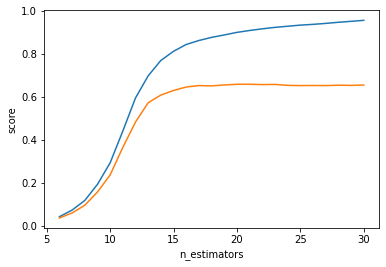

In [8]:
cv_strategy = KFold(n_splits=5)

n_trees, current_score_train, current_score_valid  = [], [], []

for i in tqdm(range(30, 5, -1)):
    estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
    fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
    evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
        target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), 
        target_train['TST'], 
        target_train['C'],
        test.drop(['DATA_ZAMERA'], axis=1),
        estimator_1=xgb.XGBRegressor(n_estimators=i, random_state=1), 
        estimator_2=xgb.XGBRegressor(n_estimators=i, random_state=1),
        metric=r2_score, 
        cv_strategy=cv_strategy,
        error_to_be_outlier=None,
    )
    
    current_score_train.append(evraz_metric_train_scores_mean)
    current_score_valid.append(evraz_metric_valid_scores_mean)
    n_trees.append(i)

plt.plot(n_trees, current_score_train)
plt.plot(n_trees, current_score_valid)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show();

In [9]:
cv_strategy = KFold(n_splits=5)
#cv_strategy = StratifiedKFold(n_splits=5)

n_trees=16

estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
    target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), 
    target_train['TST'], 
    target_train['C'],
    test.drop(['DATA_ZAMERA'], axis=1),
    estimator_1=xgb.XGBRegressor(n_estimators=n_trees, random_state=1), 
    estimator_2=xgb.XGBRegressor(n_estimators=n_trees, random_state=1),
    metric=r2_score, 
    cv_strategy=cv_strategy,
    error_to_be_outlier=None,
)

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7664, train-score 2 = 0.9757
valid-score 1 = 0.3112, valid-score 2 = 0.6692
Train metric =  0.8445
Valid metric =  0.5521
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7623, train-score 2 = 0.9726
valid-score 1 = 0.4578, valid-score 2 = 0.6378
Train metric =  0.84
Valid metric =  0.6973
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.761, train-score 2 = 0.976
valid-score 1 = 0.4123, valid-score 2 = 0.6913
Train metric =  0.8533
Valid metric =  0.6356
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7376, train-score 2 = 0.975
valid-score 1 = 0.5667, valid-score 2 = 0.6718
Train metric =  0.8322
Valid metric =  0.693
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7755, train-score 2 = 0.973
valid-score 1 = 0.395, valid-score 2 = 0.7213
Train metric =  0.8455
Valid metric =  0.6481
CV-

In [10]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_pred_1).rename('TST'), 
                    pd.Series(test_pred_2).rename('C')
                   ],
                   axis=1
                  )
print(submit.shape)
submit.head(5)

(780, 3)


,NPLV,TST,C
0,512324,1649.668823,0.057407
1,512327,1665.674683,0.059847
2,512328,1642.202393,0.107615
3,512331,1647.192017,0.085792
4,512333,1660.180786,0.121748


In [11]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'xgb_n-tree-16_with_gas_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  xgb_n-tree-16_with_gas_2021-10-31_06-05-38.csv

 File saved to disk!
